## Supervised Learning
## Project: Finding Donors for *CharityML*

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

> This uses **Python 3**

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data.income=='>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data.income=='<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100.0

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

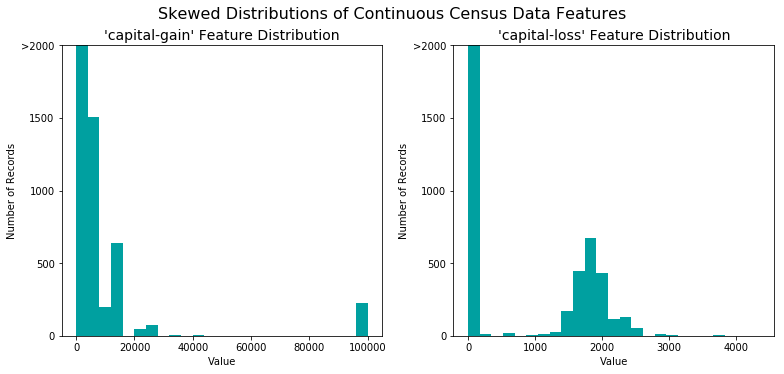

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

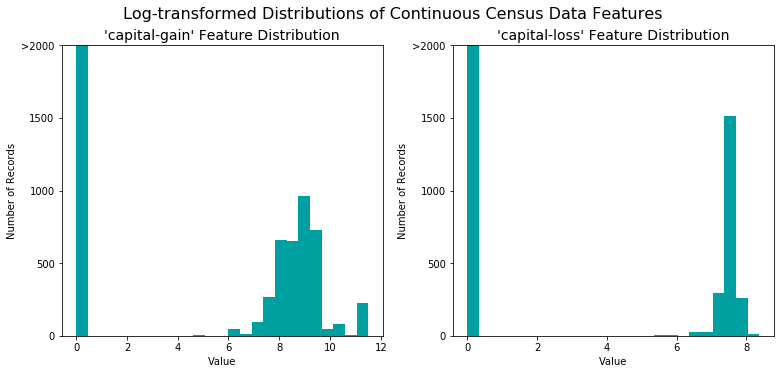

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|  * | someFeature |         *           | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  | * | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  | * | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K': 0, '>50K': 1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.\n".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print('\n'.join(['%i: %s' % (n+1, encoded[n]) for n in range(len(encoded))]))

103 total features after one-hot encoding.

1: age
2: education-num
3: capital-gain
4: capital-loss
5: hours-per-week
6: workclass_ Federal-gov
7: workclass_ Local-gov
8: workclass_ Private
9: workclass_ Self-emp-inc
10: workclass_ Self-emp-not-inc
11: workclass_ State-gov
12: workclass_ Without-pay
13: education_level_ 10th
14: education_level_ 11th
15: education_level_ 12th
16: education_level_ 1st-4th
17: education_level_ 5th-6th
18: education_level_ 7th-8th
19: education_level_ 9th
20: education_level_ Assoc-acdm
21: education_level_ Assoc-voc
22: education_level_ Bachelors
23: education_level_ Doctorate
24: education_level_ HS-grad
25: education_level_ Masters
26: education_level_ Preschool
27: education_level_ Prof-school
28: education_level_ Some-college
29: marital-status_ Divorced
30: marital-status_ Married-AF-spouse
31: marital-status_ Married-civ-spouse
32: marital-status_ Married-spouse-absent
33: marital-status_ Never-married
34: marital-status_ Separated
35: marital-stat

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

**HINT:** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
# Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.
TP = np.sum(income) 
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2) * (precision * recall) / (0.5**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**HINT:**

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer:**

In machine learning, there is something called the "No Free Lunch" theorem. In a nutshell, it states that no one algorithm works best for every problem, and it is especially true for supervised learning. We can't simply say that Decission Trees are always better than Support Vector Machines or vice-versa because there are many factors at play, such as the size and structure of the dataset.

As a result, we should try  different algorithms for the problem at hand, while using a separate test set of data to evaluate performance and select the winner.

Below are the top three choices of algorithms for this problem, each providing an answer to four questions above.


### Logistic Regression

**Description**

Despite its confusing name, Logistic Regression is a model for classification, not regression. It is one of the most widely used classification algorithms in the industry, the "go-to method" for binary classification. It's simple enough to be used as a performance baseline, it's easy to implement and it will do well enough in many tasks. 

It works by measuring the relationship between the dependent variable (the label we want to predict) and the one or more independent variables (the features), by estimating probabilities using its underlying logistic function. These probabilities must then be transformed into binary values in order to actually make a prediction. This is the task of the _logistic function_, also called the _sigmoid function_. The Sigmoid-Function is an S-shaped curve that can take any real-valued number and map it into a value between the range of 0 and 1, but never exactly at those limits. This values between 0 and 1 will then be transformed into either 0 or 1 using a threshold classifier.

<img src="https://machinelearningblogcom.files.wordpress.com/2018/04/bildschirmfoto-2018-04-23-um-12-05-381.png?w=1472" style="height: 300px" />

<img src="https://machinelearningblogcom.files.wordpress.com/2018/04/bildschirmfoto-2017-11-30-um-10-01-17.png" style="height: 300px" />

**Types of Logistic Regression**
+ _Binary Logistic Regression_: The target variable has only two possible outcomes such as Spam or Not Spam, Cancer or No Cancer.
+ _Multinomial Logistic Regression_: The target variable has three or more nominal categories such as predicting the type of Wine.
+ _Ordinal Logistic Regression_: the target variable has three or more ordinal categories such as restaurant or product rating from 1 to 5.

**Applications**
- In _weather forecasting_, not only to predict if it will rain on a particular day but also report the chance of rain
- In _medicine_, it can be used to predict the chance that a patient has a particular disease given cetain symptoms, for example diabetis prediction
- In _marketing_, it can be used to predict whether a certain customer will purchase a certain product or default to a competitor, or whether a user will click on the ad link or not

**Strengths**
+ Easy to implement
+ Performs very well on linearly separatable classes
+ Can be extended to multiclass classification
+ Fast to train
+ It doesn't require tuning and scaling of features
+ Providers a probability score for observations

**Weaknesses**
+ Can't solve non-linear problems
+ Will not perform well with independent variables that are not correlated to the target variable and are very similar or correlated to each other 
+ Not able to handle a large number of categorical features
+ Vulnerable to overfitting
+ Requires a large sample size; a general guideline is that you need at minimum of 10 cases with the least frequent outcome for each independent variable in your model, for example, if you have 5 independent variables and the expected probability of your least frequent outcome is .10, then you would need a minimum sample size of 500 (10*5 / .10) [Rule of 10](https://en.wikipedia.org/wiki/Logistic_regression#%22Rule_of_Ten%22)

**Why choose it?**
Our problem is a binary classification one and usually, Logistic Regression is a good place to start, to have a baseline for other more complex algorithms. It's very fast compared to other algorithms, like SVM, and performs decently well.

**References**
+ [Understanding Logistic Regression in Python](https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)
+ [Preprocessing in Data Science (Part 2): Centering, Scaling and Logistic Regression](https://www.datacamp.com/community/tutorials/preprocessing-in-data-science-part-2-centering-scaling-and-logistic-regression)
+ [The Logistic Regression Algorithm](https://machinelearning-blog.com/2018/04/23/logistic-regression-101/)
+ [The Dissadvantates of Logistic Regression](https://www.theclassroom.com/disadvantages-logistic-regression-8574447.html)

### Random Forest

**Description**
Random forest is a versatile machine learning method with numerous applications ranging from marketing to healthcare and insurance. It belongs to a larger cass of machine learning algorithms called Ensemble Methods, more precisely Bagging, which involves building many independent predictors/models/learners and combine them using averaging techniques. 

_Ensemble learning_ involves the combination of several models to solve a single prediction problem. It works by generating multiple classifiers/models which learn and make predictions independently. Those predictions are then combined into a single (mega) prediction that should be as good or better than the prediction made by any one classifer. Random Forest is an ensamble of decision trees. It will create a bunch of random decision trees automatically but since the trees are generated at random, most will not be all that meaningful to the classification/regression problem. 

<img src="http://blog.yhat.com/static/img/a_random_forest.png" style="height: 250px" />

**Applications**
- Model the impact of marketing on customer acquisition, retention, and churn
- Predict disease risk and susceptibility in patients
- Predicting outcomes of legal cases

**Strengths**
+ Capable of regression and classification
+ Can handle a large number of features
+ Helpful for estimating which of the variables are important in the underlying data being modeled
+ Doesn't require much tuning, unlike, for example SVM
+ Good for feature selection, because one of the consequences of trying multiple decision tree variations is that it is possible to examine which variables are working best/worst in each tree

**Weaknesses**
+ More time-consuming to train than Decision Trees
+ Prone to overfitting with small data sets
+ Don't work well with imbalanced data
+ Hard to understand the prediction

**Why choose it?**
Like Logistic Regression, Random Forest works well in most cases so it is good as first or second choice to try. Also, being an Ensemble method, it should perform better than other standalone algorithms, like Decision Trees.

**References**
+ [Random Forests in Python](http://blog.yhat.com/posts/random-forests-in-python.html)
+ [Demystifying the Random Forest](https://www.kaggle.com/akashram/demystify-the-random-forest)
+ [Introduction to Random Forest](https://dimensionless.in/introduction-to-random-forest/)
+ [The Unreasonable Effectiveness of Random Forests](https://medium.com/rants-on-machine-learning/the-unreasonable-effectiveness-of-random-forests-f33c3ce28883)
+ [Pros and Cons of Top Predictive Algorithms Infographic](https://thereputationalgorithm.com/2017/01/21/top-predictive-algorithms-infographic/)

### AdaBoost

**Description**
AdaBoost (Adaptive Boosting) is a popular boosting technique which helps you combine multiple "weak classifiers" into a single "strong classifier". A weak classifier is simply a classifier that performs poorly, but performs better than random guessing. AdaBoost can be applied to any classification algorithm, so it’s a meta-algorithm that builds on top of other classifiers as opposed to being a classifier itself. Unlike Bagging, Boosting is an ensemble technique in which the predictors are not made independently, but sequentially. This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors. By default, Adaboost uses a decision stump i.e. a decision tree of depth 1 as its base classifier, which can handle categorical and numerical data. Weak learners are relatively faster to train, so the dataset size is not a problem for the algorithm.

<img src="https://quantdare.com/wp-content/uploads/2016/04/bb2.png" style="height: 250px;"/>

**Applications**
+ The Viola-Jones face detector, a standard algorithm for detecting faces in an image
+ People and places detection and tracking

**Strengths**
+ Can be used with many different classifiers
+ Not prone to overfitting
+ Simple to implement

**Weaknesses**
+ Sensitive to noisy data and outliers
+ A bit less flexible than Gradient Boosting
+ The weak classifier must be better than chance

**Why choose it?**
AdaBoost is the base meta-algorithm for Boosting, which builds on top of other classifiers, including Decision Stumps and SVMs. The cascade architecture is used to raise the efficiency of the system. The true and false positives passed at the current stage will be used in the next stage of the cascade. The goal is to reduce the false positive rate faster than the detection rate. This means that it's good for our particular case where the model's ability to precisely predict those that make more than $50,000 is more important than the model's ability to recall those individuals.

**References**
+ [Explaining AdaBoost](http://rob.schapire.net/papers/explaining-adaboost.pdf)
+ [AdaBoost Classifier in Python](https://www.datacamp.com/community/tutorials/adaboost-classifier-python)
+ [What is the difference between Bagging and Boosting?](https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/)
+ [Boosting Algorithms: AdaBoost, Gradient Boosting and XGBoost](https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c)



### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


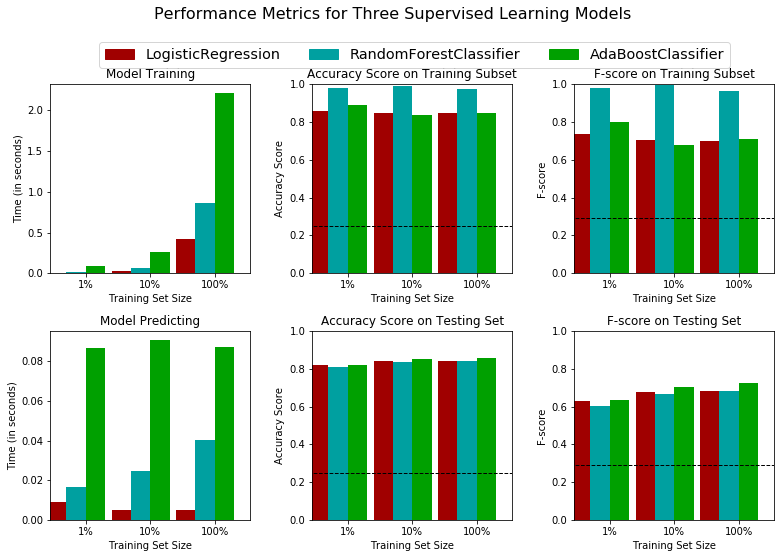

LogisticRegression


,1%,10%,100%
acc_test,0.818684,0.838585,0.841902
acc_train,0.860000,0.846667,0.846667
f_test,0.628860,0.677507,0.683165
f_train,0.738636,0.703125,0.698529
pred_time,0.008951,0.004875,0.004871
train_time,0.005865,0.030150,0.419196


RandomForestClassifier


,1%,10%,100%
acc_test,0.808292,0.833610,0.843118
acc_train,0.980000,0.993333,0.973333
f_test,0.603513,0.664743,0.684179
f_train,0.982143,0.994318,0.967262
pred_time,0.016751,0.024793,0.040176
train_time,0.018061,0.058175,0.856850


AdaBoostClassifier


,1%,10%,100%
acc_test,0.820674,0.849862,0.857601
acc_train,0.893333,0.840000,0.850000
f_test,0.632757,0.701882,0.724551
f_train,0.801282,0.680147,0.711538
pred_time,0.086716,0.090804,0.087389
train_time,0.090322,0.254681,2.210099


In [10]:
# TODO: Import the three supervised learning models from sklearn
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import  AdaBoostClassifier, RandomForestClassifier
#from sklearn.ensemble import  GradientBoostingClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import SGDClassifier
#from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=42)
clf_B = RandomForestClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

# Print out the numerical results
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

**HINT:** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer:**

Based on the visualisations above, AdaBoost is the best algorithm out of the ones chosen for this problem, when taking into account both the F-beta score and the prediction times on the 100% test set:
+ Has the highest f_beta score in testing (0.724) vs 0.683 for Logistic Regression and 0.679 for Random Forest
+ Has the highest accuracy score in testing (0.857) vs 0.841 for Logistic Regression and 0.843 for Random Forest
+ Has good prediction speed (0.088) although not as fast as Random Forest (0.051) or Logistic Regression (0.004)
+ The biggest inconvenience is the training time, which is the longest of the three by far; however the assumption is that, since the data comes from census, which is collected every few years, the performance is acceptable given that CharityML doesn't need to process a constant stream of data 
+ As an Ensemble method, it is the least susceptible to overfitting and shows consistent accuracy and F-beta scores in both training and testing; by comparison, the other two algorithms show a higher F-beta and accuracy score in training set but fail to produce the same results in testing
+ The data is mainly discrete with 103 features and not overly noisy; algorithms based on decision trees or stumps are good at detecting the important features

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

**HINT:**

When explaining your model, if using external resources please include all citations.

**Answer:**

AdaBoost comes from Adaptive Boosting and it's something called an ensemble model. An ensemble is a composite model which combines a series of low performing classifiers with the aim of creating an improved classifier. 
To use a real-life methaphor to describe how it works, imagine you want to win a science quiz but instead of doing it alone you team up with your friends. Your strategy is to exploit what each of your friend is best at. For example, your mathematician friend is going to answer well all the math questions but will not do so well in chemistry. Your chemist friend will answer the test and focus on the chemistry questions but she won't know much about sports. Luckly, you have a sports fan friend in your team. He will not to great with the science questions but will answer all the sports related ones. At the end, you have combined strengths of your friends (aka the "weaker learners") into a single strong winning team (aka a "strong learner"). 

For AdaBoost, the process works as follows:
1. The first learner's goal is  to maximise accuracy, i.e. minimise the number of errors. It has to be better than random guess. Let's take an example of 7 points that we want to classify. Initially all the points are assigned a weight of 1. Assuming the first learner classifies correctly 7 points out of 10, then the sum of weights of correctly classified points is 7 and the sum of weights of misclassified points is 3.


2. The second learner needs to fix some of the mistakes the first learner has made, so the misclassified points get higher weights. For example, the 3 misclassifed points will get their weights increased by a factor of 7/3 = 2.33. The sum of weights of correctly classified points is 7 and the sum of weights of misclassified points is also 7. This is so that in the next iterations the misclassified points will get a higher chance of being classified correctly.


3. The third learner focuses on classifying the points with higher weights. Assuming that now the three points are classified correctly and there are 3 more points classified incorrectly, the sum of weights is 11 (= 3 classified correctly from previously with a weight sum of 7 and 4 classified correctly in this iteration, with a sum of 4) for the correctly classified ones and 3 for the misclassified ones. Again, the misclassified points get a higher weight, now 11/3 = 3.66. The sums of correctly classified points and the misclassified one are now both 11.

5. This process iterate until the complete training data fits without any error or until reached to the specified maximum number of estimators.


6. Each model gets a score for classifying the points, also called a weight. This weight is obtained by applying the natural logarithm function to the faction of correctly classified number of points over the misclassified ones. For example, the first model gets a weight of `ln(7/3)` for correctly classifying 7 points and misclassifying 3. The reason behind the logarith function is to try to assign good models a weight closer to 1, the bad models a weight closer to -1 and to random model a weight of 0. 


7. In extreme cases of a model that perfectly classifies all the points, to avoid an undefined number by dividing by zero, the model is considered perfect, and has a weight of infinity. Similarly, a model that misclassifies everything gets a weight of minus infinity.


8. At the end, the result is obtained by a vote from all the learners, with the votes being weighted accordingly with the weight of each model.  

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1542651255/image_3_nwa5zf.png" style="height: 350px;" />

References:
+ [Machine Learning Engineer Udacity Lesson 18 AdaBoost](https://classroom.udacity.com/nanodegrees/nd009t/parts/f873e6c9-5147-4e90-abc7-084afe9da5a1/modules/25f6d67e-fd75-4e4b-8fc1-20fc46674546/lessons/b24abad5-6654-4c9f-a54d-821d3d22e901/concepts/331fb696-7767-4adb-b729-31972d00453f)
+ [AdaBoost Classifier in Python](https://www.datacamp.com/community/tutorials/adaboost-classifier-python)

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [11]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state = 42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators':[50, 100, 200], 
              'learning_rate':[0.1, 0.5, 1.]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
# Print the best estimator
print(best_clf)

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8651
Final F-score on the testing data: 0.7396
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=42)


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |    0.8576         |   0.8651        |
| F-score        |    0.7246         |   0.7396        |


**Answer:**

The optimised model had better accuracy and F-score vs the unoptimised one, but not by much: 

|     Metric     | Unoptimized Model | Optimized Model | Naive Predictor |
| :------------: | :---------------: | :-------------: | :-------------: |
| Accuracy Score |    0.8576         |   0.8651        |   0.2478        |
| F-score        |    0.7246         |   0.7396        |   0.2917        |

In both cases, the results were considerable better than the naive classifier obtained in **Question 1**.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

The features that are more likely to be important for predictions are:
+ **capital-loss**:
> [Capital loss](https://www.investopedia.com/terms/c/capitalloss.asp) is the loss incurred when a capital asset, such as an investment or real estate, decreases in value. This loss is not realized until the asset is sold for a price that is lower than the original purchase price.


+ **capital-gain**:
> [Capital gain](https://www.investopedia.com/terms/c/capitalgain.asp) is a rise in the value of a capital asset (investment or real estate) that gives it a higher worth than the purchase price. The gain is not realized until the asset is sold. A capital gain may be short-term (one year or less) or long-term (more than one year) and must be claimed on income taxes.

Individuals who have sold their assets (with profit or loss) when the Census data was captured would see their reported income would be massively influenced by these two factors.
+ **age**: generally, older people have had time to accumulate more wealth than people in their 20s for example
+ **occupation**: an `Exec-managerial` position will pay much more than `Craft-repair` for example
+ **workclass**: being in `Private` employment will earn more than `Without-pay` for example

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

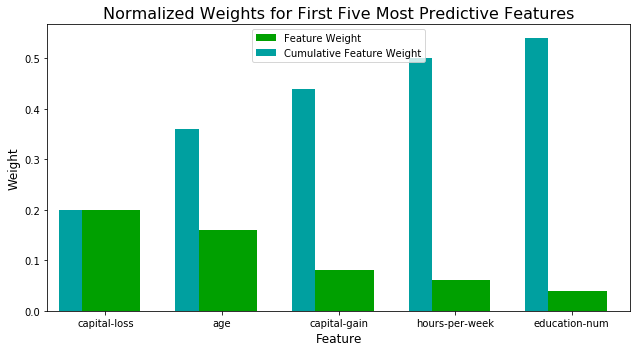

In [12]:
# TODO: Import a supervised learning model that has 'feature_importances_'
clf = AdaBoostClassifier(random_state = 42)

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

_What feature importance is_:
The importance of a feature is measured by calculating the increase in the model’s prediction error after permuting the feature. A feature is “important” if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is “unimportant” if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction.

The higher the number, the most important the feature is.

Reference:
[Feature Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

_Why show the cumulative weights_:
The feature weight indicates the importance of an individual feature. The cumulative weights are shown to understand how that feature compares to the rest. The total weights of the features will add up to 1. This means that a feature with weight 0.2 is very, very important in a data set with 1000 features but not so in a data set of only 5 features. The cumulative feature weight indicates the weight for that feature plus any other more important features (moving left to right). This gives a sense for the total importance of the five most important features in the dataset. 

In the example above, the top five features account for more than half the total weight of all 103 features, which shows significance.

_How the answers compare_:
- The features predicted correctly were `age`, `capital-loss` and `capital-gain`.
- The visualisation confirms that the `age`, `capital-loss` and `capital-gain` are among the top five most predictive features. 

There were a few surprising and interesting things to note.
- When comparing the feature weight, `capital-loss` seems more important than both `capital-gain`. Capital means assets and/or stocks and bonds that are counted separately from the salary income. It was tricky to come to an explanation. The way to approach it was to think 'Why would someone have capital loss in the first place? Why would someone sell their assets at a loss?'. A plausible explanation is that someone would sell at a loss if they would already be in financial difficulties and would be forced to sell at the wrong time. Which might make `capital-loss` more indicative of financial difficulties and earning less than `50K` than `capital-gain`. An individual making more than 50K from their salary would not be affected much in terms of prediction by having an extra `capital-gain` while `capital-loss` might bring an individual that was above the 50K threshold below it.
- The other surprising thing is that the number of years of education, `education_num` was found more important than `occupation` and `workclass`. The thinking was that certain occupations, like managerial positions, with a Bachelor or Master degree would often bring a higher income than say a professor with a PhD. For `workclass` the thinking was that private employement might result in higher income than being self employed or not employed at all.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [13]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8651
F-score on testing data: 0.7396

Final Model trained on reduced data
------
Accuracy on testing data: 0.8385
F-score on testing data: 0.6920


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

Both the accuracy and the f-score are lower when using reduced data compared to when using all features.

|     Metric     |  Full Data | Reduced Data |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |    0.8651        |   0.8385        |
| F-score        |    0.7396         |   0.6920       |

In this case, it is important for the model to be precised, so the training time has to be balanced with the accuracy and precision of prediction. In this case I wouldn't use the reduce data because the f-score is significantly lower on the reduced data.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [14]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 521256 bytes to finding_donors.html']